# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks'

In [2]:
# Concurrency config
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [3]:
# Notebook utils
from nb_utils import (get_test_data_loader, load_config, load_summaries,
                      load_model, apply_model, compute_metrics,
                      plot_train_history, draw_sample, plot_metrics)

In [4]:
%matplotlib inline

In [5]:
# Config path
config_file = '../configs/resmpnn_big.yaml'

In [6]:
!cat $config_file

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `module'
output_dir: ${SCRATCH}/heptrkx/results/resmpnn_big_002

trainer:
    name: gnn_sparse
    real_weight: 5.0   # 0.5 / 0.1
    fake_weight: 0.555 # 0.5 / 0.9

data:
    name: hitgraphs_sparse
    input_dir: ${SCRATCH}/heptrkx/data/hitgraphs_big_000
    n_train: 32768
    n_valid: 4096
    batch_size: 1
    n_workers: 4

model:
    name: resmpnn
    input_dim: 3
    hidden_node_dim: 64
    hidden_edge_dim: 64
    n_graph_iters: 8
    loss_func: binary_cross_entropy_with_logits
    optimizer: Adam
    learning_rate: 0.001

training:
    n_epochs: 96


In [7]:
config = load_config(config_file)
summaries = load_summaries(config)

/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks/nb_utils.py:33: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(f)


In [8]:
config

{'output_dir': '${SCRATCH}/heptrkx/results/resmpnn_big_002',
 'trainer': {'name': 'gnn_sparse', 'real_weight': 5.0, 'fake_weight': 0.555},
 'data': {'name': 'hitgraphs_sparse',
  'input_dir': '${SCRATCH}/heptrkx/data/hitgraphs_big_000',
  'n_train': 32768,
  'n_valid': 4096,
  'batch_size': 1,
  'n_workers': 4},
 'model': {'name': 'resmpnn',
  'input_dim': 3,
  'hidden_node_dim': 64,
  'hidden_edge_dim': 64,
  'n_graph_iters': 8,
  'loss_func': 'binary_cross_entropy_with_logits',
  'optimizer': 'Adam',
  'learning_rate': 0.001},
 'training': {'n_epochs': 96}}

In [9]:
summaries

,epoch,lr,train_loss,train_time,valid_acc,valid_loss,valid_time
0,0,0.001,0.237071,2005.282812,0.948282,0.128986,76.043061
1,1,0.001,0.129646,2022.251159,0.964866,0.093863,77.122838
2,2,0.001,0.114975,1985.824389,0.969409,0.084508,74.170162
3,3,0.001,0.103742,1996.625650,0.971775,0.079110,76.538326
4,4,0.001,0.089792,1975.954755,0.974735,0.072144,74.148633
5,5,0.001,0.081483,1979.650768,0.979441,0.061672,76.138254
6,6,0.001,0.074791,1899.101200,0.980861,0.056074,66.491067
7,7,0.001,0.071169,1899.639762,0.983235,0.050605,67.026508
8,8,0.001,0.070390,1908.122570,0.979204,0.059674,67.063254
9,9,0.001,0.066600,1887.319324,0.981697,0.053656,67.143901


## Plot the Training loss and accuracy

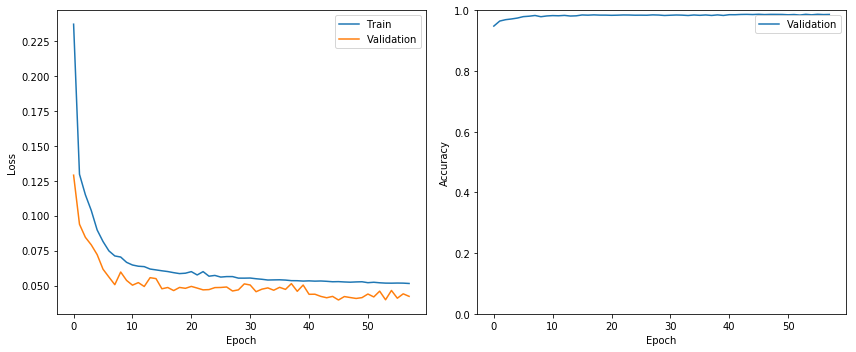

In [10]:
plot_train_history(summaries)

## Load the trained model

In [11]:
# Find the best epoch
best_summary = summaries.loc[[summaries.valid_loss.idxmin()]]
best_summary

,epoch,lr,train_loss,train_time,valid_acc,valid_loss,valid_time
45,45,0.001,0.05279,1899.940239,0.9872,0.039631,65.585798


In [12]:
# Load model from best epoch
model = load_model(config, reload_epoch=best_summary.epoch).eval()

print(model)
print('Parameters: %i' % sum(p.numel() for p in model.parameters()))

GNN(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): ReLU

## Load the test data set

In [13]:
import torch
from torch.utils.data import Subset, DataLoader

from torch_geometric.data import Batch

from datasets.hitgraphs_sparse import HitGraphDataset

from nb_utils import get_input_dir

def get_dataset(config):
    return HitGraphDataset(get_input_dir(config))

def get_test_data_loader(config, n_test=16):
    # Take the test set from the back
    full_dataset = get_dataset(config)
    test_indices = len(full_dataset) - 1 - torch.arange(n_test)
    test_dataset = Subset(full_dataset, test_indices)
    return DataLoader(test_dataset, batch_size=1, collate_fn=Batch.from_data_list)

In [14]:
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

## Evaluate the model on the test dataset

In [15]:
import torch

@torch.no_grad()
def apply_model(model, data_loader):
    preds, targets = [], []
    for batch in data_loader:
        preds.append(torch.sigmoid(model(batch)).squeeze(0))
        targets.append(batch.y.squeeze(0))
    return preds, targets

In [16]:
%%time
test_preds, test_targets = apply_model(model, test_loader)

CPU times: user 2min 56s, sys: 3.3 s, total: 3min
Wall time: 45.3 s


In [17]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9871
Precision: 0.8783
Recall:    0.9702


In [18]:
threshold = 0.6
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.6
Accuracy:  0.9892
Precision: 0.9029
Recall:    0.9653


In [19]:
threshold = 0.7
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.7
Accuracy:  0.9908
Precision: 0.9261
Recall:    0.9588


In [20]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9921
Precision: 0.9511
Recall:    0.9480


In [21]:
threshold = 0.85
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.85
Accuracy:  0.9926
Precision: 0.9646
Recall:    0.9399


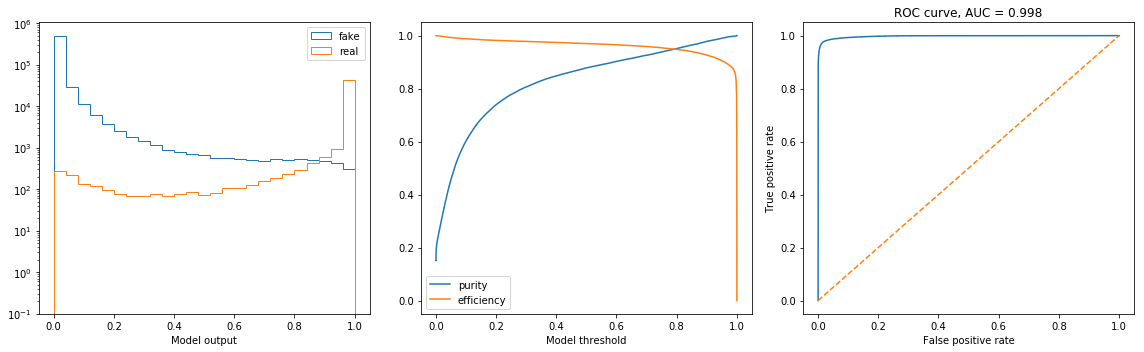

In [22]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [23]:
def draw_sample(data, cmap='bwr_r', alpha_labels=True, figsize=(15, 7)):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]

    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
    cmap = plt.get_cmap(cmap)

    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')

    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$z$')
    ax1.set_xlabel('$\phi$')
    ax0.set_ylabel('$r$')
    ax1.set_ylabel('$r$')
    plt.tight_layout()